Load data for network from file

In [4]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline
sess = tf.InteractiveSession()
    

/home/ric/Projects/Hull/HOMLWSLTF/env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [5]:
with open("datasets/wine/wine_train.json") as json_data:
    dataset = json.load(json_data)

train_x = np.asarray(dataset["attribs"])
train_y = np.asarray(dataset["target_hot"])

In [6]:
class TfAnn(object):
    
    def __init__(self):
        self.hidden=[]
        self.np_hidden=[]
        
        self.n_nodes=[]
        self.n_classes = 0
        self.n_hiden_layers = 0

    
    def init_empty(self,layers,n_classes,size):
        self.n_classes = n_classes
        self.n_hiden_layers = len(layers)
        for i in range(self.n_hiden_layers):
            self.hidden.append({'weights':[],'biases':[]})
            self.np_hidden.append({'weights':[],'biases':[]})
            self.n_nodes.append(layers[i])
        self.output_layer = {'weights':[],'biases':[]}
        self.np_output_layer={"weights":[],"biases":[]}

        for i in range(self.n_hiden_layers):
            self.hidden[i] = {'weights':tf.Variable(tf.random_normal([size, self.n_nodes[i]])),
                      'biases':tf.Variable(tf.random_normal([self.n_nodes[i]]))}
            
        self.output_layer = {'weights':tf.Variable(tf.random_normal([self.n_nodes[-1], self.n_classes])),
                        'biases':tf.Variable(tf.random_normal([self.n_classes]))}


    def init_json(self,jfile):
        with open(jfile) as json_data:
            tf_data = json.load(json_data)
        self.n_classes = tf_data["n_classes"]
        self.n_hiden_layers = tf_data["n_hiden_layers"]
        self.hidden =tf_data["hidden"]
        self.output_layer =tf_data["output"]


    def create(self,data):
        # This is the heart of the ann where multiply the data by the wights to the layers 
        for i in range(self.n_hiden_layers):
            layer = tf.add(tf.matmul(data,self.hidden[i]['weights']), self.hidden[i]['biases'])
            layer= tf.nn.relu(layer)
        output =  tf.add(tf.matmul(layer,self.output_layer['weights']) , self.output_layer['biases'])
        return output
    
    def extract(self,jfile):
        for i in range(self.n_hiden_layers):
            self.np_hidden[i]["weights"] = neural_network_model.hidden[i]["weights"].eval().tolist()
            self.np_hidden[i]["biases"] = neural_network_model.hidden[i]["biases"].eval().tolist()
        self.np_output_layer["weights"] = neural_network_model.output_layer["weights"].eval().tolist()
        self.np_output_layer["biases"] = neural_network_model.output_layer["biases"].eval().tolist()
        with open(jfile,"w") as jout:
            json.dump({"n_classes":self.n_classes,"n_hiden_layers":self.n_hiden_layers ,"hidden":self.np_hidden,"output":self.np_output_layer},jout)
        
        

In [7]:
def train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test,hm_epochs):
    x = tf.placeholder('float')
    y = tf.placeholder('float')
    prediction = neural_network_model.create(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    init = tf.initialize_all_variables()
    sess.run(init)
    losses=[]
    for epoch in range(hm_epochs):
            _, c = sess.run([optimizer, cost], feed_dict={x:x_data_train,
                                                          y:y_data_train})
            losses.append(c)
    cf = test_neural_network(neural_network_model,x_data_test,y_data_test)
    return cf,losses
   

In [8]:
def test_neural_network(neural_network_model,x_data_test,y_data_test):
    x = tf.placeholder('float')
    prediction = neural_network_model.create(x)    
    y_test_res=(sess.run(prediction,feed_dict={x:x_data_test}))       
    true_class=np.argmax(y_data_test,1)
    predicted_class=np.argmax(y_test_res,1)
    cm = confusion_matrix(predicted_class,true_class)
    cm = cm.astype('float')*10000 / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, copy=True)
    cm = cm.astype('int')
    return cm*0.01

In [9]:
from sklearn.model_selection import StratifiedKFold
train_index=[]
test_index=[]
splits =5
skf = StratifiedKFold(n_splits=splits,random_state=0,shuffle=True)
for train_idx, test_idx in skf.split(train_x,train_y[:,0]):               
    train_index.append(train_idx)
    test_index.append(test_idx)

In [10]:
import seaborn as sns
def plot_confusion_matrix(cm, classes, title,classifier_name):
    plt.rcParams.update({'font.size': 18})
    fig,ax= plt.subplots(figsize=(5,4))
    sns.set(font_scale=1.5)
    sns_plot = sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
array([[100.  ,   0.  ,   0.  ],
       [  7.69,  92.3 ,   0.  ],
       [  0.  ,   0.  , 100.  ]])


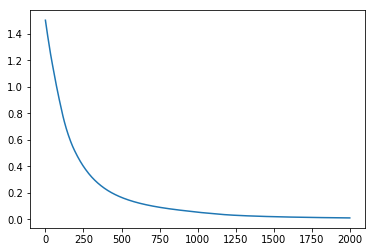

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


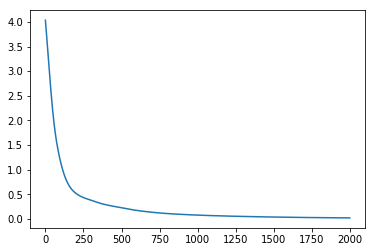

array([[100.  ,   0.  ,   0.  ],
       [  0.  ,  92.85,   7.14],
       [  0.  ,   0.  , 100.  ]])


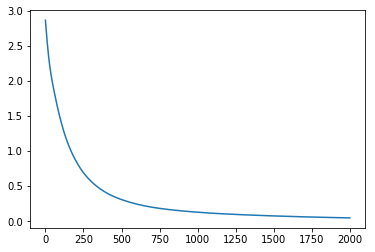

array([[ 90.,  10.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


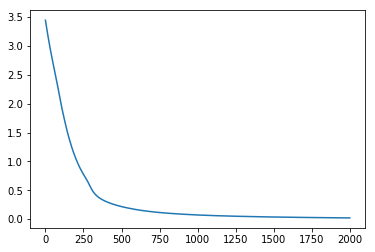

array([[ 90.,  10.,   0.],
       [  0., 100.,   0.],
       [  0.,  25.,  75.]])


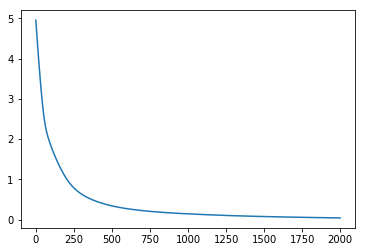

array([[96.   ,  4.   ,  0.   ],
       [ 1.538, 97.03 ,  1.428],
       [ 0.   ,  5.   , 95.   ]])


In [11]:
av_cf = np.empty([3,3,0])
for fold in range(splits):
    neural_network_model = TfAnn()
    neural_network_model.init_empty([13],len(train_y[0]),len(train_x[0]))
    x_data_train = train_x[train_index[fold]]
    y_data_train = train_y[train_index[fold]] 
    x_data_test = train_x[test_index[fold]]
    y_data_test = train_y[test_index[fold]]
    cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test,2000)
    av_cf = np.dstack([av_cf,cf])
    pprint( cf)
    #plot_confusion_matrix(cf,[1,2,3],"Cf matrix","wine")
    plt.plot(loss)
    plt.show()
pprint(av_cf.mean(axis=2))

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]])


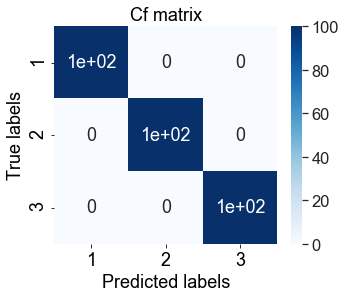

In [12]:
neural_network_model = TfAnn()
neural_network_model.init_empty([13],len(train_y[0]),len(train_x[0]))
x_data_train = train_x
y_data_train = train_y
x_data_test = train_x
y_data_test = train_y
cf,loss = train_neural_network_interactive(neural_network_model,x_data_train,y_data_train,x_data_test,y_data_test,2000)
pprint(cf)
plot_confusion_matrix(cf,[1,2,3],"Cf matrix","wine")
plt.show()

In [13]:
neural_network_model.extract("classifiers/wine-mlp.json")